In [5]:
import sys
print(sys.version)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [ ]:
# !cat /proc/cpuinfo

In [ ]:
# !nvidia-smi

In [6]:
import os
import pandas as pd
import numpy as np
import math
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import random
%matplotlib inline
import cv2
from tqdm.auto import tqdm

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer,  OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report # 정오분류표 # 정확도, 민감도 등

In [ ]:
print(tf.__version__)

2.7.0


In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = '/content/drive/MyDrive/졸업논문/'
LABELS_CSV_PATH = "/content/drive/MyDrive/졸업논문/dataset/labels_0929.xlsx"
IMAGES_PATH = "/content/drive/MyDrive/졸업논문/dataset/all_images/"

In [7]:
df = pd.read_excel(LABELS_CSV_PATH)

In [ ]:
df.head()

,Date,company,code,filenames,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,up_down,rsi,roc,SSE,roc_target,rsi_target,rsi_label,vol_label
0,2020-02-07,DRB동일,004840.KS,004840.KS_1,5370.0,5370.0,5140.0,5140.0,5101.641602,24691,5263.333333,5312.000000,5396.000000,5424.500000,down,39.552592,-2.281369,16.641847,up,up,0,3
1,2020-02-07,DSR,155660.KS,155660.KS_1,4400.0,4530.0,4300.0,4300.0,4265.040527,104841,4416.666667,4482.000000,4588.500000,4630.000000,down,36.236030,-7.626208,14.557501,up,up,0,2
2,2020-02-07,GS,078930.KS,078930.KS_1,46600.0,46750.0,45650.0,45700.0,43429.933594,192347,46216.666667,46710.000000,47640.000000,48405.000000,down,20.699150,-8.600000,4.792937,up,up,0,0
3,2020-02-07,GS글로벌,001250.KS,001250.KS_1,2035.0,2060.0,1985.0,1985.0,1985.000000,321673,2028.333333,2062.000000,2130.500000,2171.750000,down,20.158590,-10.786517,8.172075,up,up,0,1
4,2020-02-07,HDC현대산업개발,294870.KS,294870.KS_1,21750.0,21850.0,20800.0,20900.0,20396.386719,427595,21238.754557,21297.247656,21373.519336,21754.185254,down,36.501767,-11.117645,8.873324,up,up,0,1


In [ ]:
df['filenames'] = df['filenames'].apply(lambda x: str(x) +'.jpg')

In [ ]:
len(df)

7783

In [ ]:
# pattern_df = pd.read_excel('/content/drive/MyDrive/졸업논문/dataset/pattern_1002.xlsx')
pattern_df = pd.read_excel('/content/drive/MyDrive/졸업논문/dataset/pattern_df_temp1116.xlsx')

In [ ]:
len(pattern_df)

6043

In [ ]:
pattern_df['pattern_label'] = pattern_df['pattern_label'].astype(str)

In [ ]:
#pattern_df.rename(columns = {'group': 'filenames','label':'pattern_label'}, inplace = True)

In [ ]:
#df = pd.merge(df,pattern_df, on = 'filenames')

In [ ]:
len(df)

7783

In [ ]:
len(pattern_df)

6043

In [ ]:
file_list = os.listdir(IMAGES_PATH) 
sr1 = pd.Series(file_list, name = 'filenames')

In [ ]:
df = pd.merge(sr1,df,on = 'filenames',how='left')

In [ ]:
df = df.dropna()

In [ ]:
df.head()

,filenames,Date,company,code,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,up_down,rsi,roc,SSE,roc_target,rsi_target,rsi_label,vol_label
0,138250.KS_12.jpg,2021-01-07,엔에스쇼핑,138250.KS,12100.0,12300.0,11900.0,12100.0,12100.0,76317,12033.333333,12080.00000,12245.000000,12180.00000,down,43.972085,-6.923077,19.342549,up,up,0,3
1,002920.KS_12.jpg,2021-01-07,유성기업,002920.KS,2745.0,2755.0,2700.0,2750.0,2750.0,105215,2768.333333,2780.00000,2775.500000,2772.25000,down,41.826358,-2.135231,19.437938,up,up,0,3
2,000100.KS_12.jpg,2021-01-07,유한양행,000100.KS,74300.0,75100.0,73500.0,75100.0,75100.0,421486,73984.127604,72352.38125,70595.238672,67202.38125,up,72.509250,22.255816,3.925275,down,down,2,0
3,088260.KS_12.jpg,2021-01-07,이리츠코크렙,088260.KS,5440.0,5440.0,5350.0,5410.0,5410.0,51461,5456.666667,5482.00000,5484.000000,5546.00000,down,28.867003,-8.460237,8.012647,down,down,0,1
4,007660.KS_12.jpg,2021-01-07,이수페타시스,007660.KS,4025.0,4060.0,3985.0,3995.0,3995.0,421648,3925.000000,3891.00000,3884.500000,3930.25000,down,50.798602,-2.679659,10.939496,down,down,1,2


In [ ]:
pattern_df = pd.merge(sr1,pattern_df,on = 'filenames',how='left')
pattern_df = pd.merge(df,pattern_df, on = 'filenames')
# pattern_df = pd.merge(pattern_df,sr1,on = 'filenames',how='left')

In [ ]:
pattern_df = pattern_df.dropna()

In [ ]:
len(pattern_df)

6043

In [ ]:
pattern_df.head()

,filenames,Date,company,code,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,up_down,rsi,roc,SSE,roc_target,rsi_target,rsi_label,vol_label,pattern_label
0,138250.KS_12.jpg,2021-01-07,엔에스쇼핑,138250.KS,12100.0,12300.0,11900.0,12100.0,12100.0,76317,12033.333333,12080.00000,12245.000000,12180.00000,down,43.972085,-6.923077,19.342549,up,up,0,3,4
2,000100.KS_12.jpg,2021-01-07,유한양행,000100.KS,74300.0,75100.0,73500.0,75100.0,75100.0,421486,73984.127604,72352.38125,70595.238672,67202.38125,up,72.509250,22.255816,3.925275,down,down,2,0,1
3,088260.KS_12.jpg,2021-01-07,이리츠코크렙,088260.KS,5440.0,5440.0,5350.0,5410.0,5410.0,51461,5456.666667,5482.00000,5484.000000,5546.00000,down,28.867003,-8.460237,8.012647,down,down,0,1,5
4,007660.KS_12.jpg,2021-01-07,이수페타시스,007660.KS,4025.0,4060.0,3985.0,3995.0,3995.0,421648,3925.000000,3891.00000,3884.500000,3930.25000,down,50.798602,-2.679659,10.939496,down,down,1,2,5
5,093230.KS_12.jpg,2021-01-07,이아이디,093230.KS,331.0,337.0,319.0,325.0,325.0,26133401,326.333333,340.40000,353.800000,360.55000,down,39.872293,-3.846154,19.973864,down,down,0,3,1


In [ ]:
df.to_excel('/content/drive/MyDrive/졸업논문/dataset/all_labels_1025.xlsx',index = False)

In [ ]:
df.to_excel('/content/drive/MyDrive/졸업논문/dataset/all_labels_1116.xlsx',index = False)

In [ ]:
df['filenames'] = df['filenames'].apply(lambda x: IMAGES_PATH+str(x))
image_ids = df.pop('filenames')

In [ ]:
pattern_df['filenames'] = pattern_df['filenames'].apply(lambda x: IMAGES_PATH+str(x))
pimage_ids = pattern_df.pop('filenames')

In [ ]:
# files = []
# for i in range(len(file_list)):
#   f= IMAGES_PATH + file_list[i]
#   files.append(f)

In [ ]:
# sr1 = pd.Series(files, name = 'filenames')

In [ ]:
# df=pd.merge(sr1,df,on = 'filenames')

In [ ]:
len(df)

7703

In [ ]:
len(file_list)

7703

In [ ]:
df = df.dropna()

In [ ]:
from keras.applications.resnet import preprocess_input
from PIL import Image

IMAGE_DIMS = (128, 128, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_data = []
for img_path in tqdm(image_ids):
  image_data.append(load_image(img_path))

image_data = np.array(image_data, dtype="float")

# np.array 저장하기
np.save('/content/drive/MyDrive/졸업논문/dataset/image_data_1117.npy',image_data)

  0%|          | 0/7703 [00:00<?, ?it/s]

In [ ]:
from keras.applications.resnet import preprocess_input
from PIL import Image

IMAGE_DIMS = (128, 128, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_data = []
for img_path in tqdm(pimage_ids):
  image_data.append(load_image(img_path))

image_data = np.array(image_data, dtype="float")

# np.array 저장하기
np.save('/content/drive/MyDrive/졸업논문/dataset/image_data_1117(6043).npy',image_data)

  0%|          | 0/6043 [00:00<?, ?it/s]

In [ ]:
image_data = []
for img_path in tqdm(image_ids):
  if img_path in files:
    image_data.append(load_image(img_path))
  else : 
    pass

image_data = np.array(image_data, dtype="float")

  0%|          | 0/7783 [00:00<?, ?it/s]

In [ ]:
len(image_data)

7703

In [ ]:
len(df)

7645

In [ ]:
from keras.applications.resnet import preprocess_input
from PIL import Image

#IMAGE_DIMS = (28, 28, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
#     #image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
#     #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

original_image_data = []
for img_path in tqdm(image_ids):
  original_image_data.append(load_image(img_path))

original_image_data = np.array(original_image_data, dtype="float")

  0%|          | 0/7703 [00:00<?, ?it/s]

In [ ]:
# np.array 저장하기
np.save('/content/drive/MyDrive/졸업논문/dataset/image_data.npy',image_data)

In [ ]:
# np.array 불러오기
image_data = np.load('/content/drive/MyDrive/졸업논문/dataset/image_data_1117.npy')   #128,128,3

In [ ]:
pimage_data = np.load('/content/drive/MyDrive/졸업논문/dataset/image_data_1117(6043).npy')   

In [ ]:
df.head()

,Date,company,code,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,up_down,rsi,roc,SSE,roc_target,rsi_target,rsi_label,vol_label
0,2021-01-07,엔에스쇼핑,138250.KS,12100.0,12300.0,11900.0,12100.0,12100.0,76317,12033.333333,12080.00000,12245.000000,12180.00000,down,43.972085,-6.923077,19.342549,up,up,0,3
1,2021-01-07,유성기업,002920.KS,2745.0,2755.0,2700.0,2750.0,2750.0,105215,2768.333333,2780.00000,2775.500000,2772.25000,down,41.826358,-2.135231,19.437938,up,up,0,3
2,2021-01-07,유한양행,000100.KS,74300.0,75100.0,73500.0,75100.0,75100.0,421486,73984.127604,72352.38125,70595.238672,67202.38125,up,72.509250,22.255816,3.925275,down,down,2,0
3,2021-01-07,이리츠코크렙,088260.KS,5440.0,5440.0,5350.0,5410.0,5410.0,51461,5456.666667,5482.00000,5484.000000,5546.00000,down,28.867003,-8.460237,8.012647,down,down,0,1
4,2021-01-07,이수페타시스,007660.KS,4025.0,4060.0,3985.0,3995.0,3995.0,421648,3925.000000,3891.00000,3884.500000,3930.25000,down,50.798602,-2.679659,10.939496,down,down,1,2


In [ ]:
tarLabels

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
rsiLB = LabelBinarizer()
#rocLB = LabelBinarizer()
volLB = LabelBinarizer()
tarLB = LabelBinarizer()
#patLB = LabelBinarizer()
# seasonLB = LabelBinarizer()
# usageLB = LabelBinarizer()

rsiLabels = rsiLB.fit_transform(np.array(df['rsi_label'].values))
#patLabels = patLB.fit_transform(np.array(df['pattern_label'].values))
volLabels = volLB.fit_transform(np.array(df['vol_label'].values))
tarLabels  = tarLB.fit_transform(np.array(df['rsi_target'].values))
# seasonLabels = seasonLB.fit_transform(np.array(df['season'].values))
# usageLabels = usageLB.fit_transform(np.array(df['usage'].values))

onehot = OneHotEncoder()
tar_onehot = onehot.fit_transform(tarLabels.reshape(-1, 1)).toarray()

split = train_test_split(image_data, rsiLabels, #patLabels, 
                         volLabels, tarLabels, tar_onehot,
                         image_ids ,
                        #  seasonLabels, 
                        #  usageLabels,
                         shuffle = False,
                         test_size=0.2, random_state=42)

(trainX, testX, 
 train_rsi_Y, test_rsi_Y,
 #train_pat_Y, test_pat_Y,
 train_vol_Y, test_vol_Y,
 train_tar_Y, test_tar_Y,
 train_tar_Y_one, test_tar_Y_one,
 train_id,test_id)  = split    ###Y들은 다 라벨값/ train 에서 라벨값, test에서 라벨값 

In [ ]:
## pattern 학습 데이터셋
patLB = LabelBinarizer()
rsiLB = LabelBinarizer()
volLB = LabelBinarizer()
tarLB = LabelBinarizer()

patLabels = patLB.fit_transform(np.array(pattern_df['pattern_label'].values))
rsiLabels = rsiLB.fit_transform(np.array(pattern_df['rsi_label'].values))
volLabels = volLB.fit_transform(np.array(pattern_df['vol_label'].values))
tarLabels  = tarLB.fit_transform(np.array(pattern_df['rsi_target'].values))


# onehot = OneHotEncoder()
# tar_onehot = onehot.fit_transform(tarLabels.reshape(-1, 1)).toarray()

split_pat = train_test_split(pimage_data, patLabels,
                             rsiLabels, volLabels, tarLabels,
                             pimage_ids ,
                        #  seasonLabels, 
                        #  usageLabels,
                         shuffle = False,
                         test_size=0.2, random_state=42)

(ptrainX, ptestX, 
 train_pat_Y, test_pat_Y,
 ptrain_rsi_Y, ptest_rsi_Y,
 ptrain_vol_Y, ptest_vol_Y,
 ptrain_tar_Y, ptest_tar_Y,
 ptrain_id,ptest_id)  = split_pat    ###Y들은 다 라벨값/ train 에서 라벨값, test에서 라벨값 

In [ ]:
onehot = OneHotEncoder()
tar_onehot = onehot.fit_transform(tarLabels.reshape(-1, 1)).toarray()

In [ ]:
tar_onehot

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
def base_cnn(IMAGE_SIZE,class_num):
  inputs = Input(shape = (IMAGE_SIZE, IMAGE_SIZE,3))
  conv1 = Conv2D(filters = 64, kernel_size = [3,3],padding='SAME',activation='relu')(inputs)
  pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

  conv2 = Conv2D(filters = 64, kernel_size = [3,3],padding='SAME',activation='relu')(pool1)
  pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
  
  conv3 = Conv2D(filters = 64, kernel_size = [3,3],padding='SAME',activation='relu')(pool2)
  pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

  pool3_flat = Flatten()(pool3)

  drop1 = Dropout(rate = 0.25)(pool3_flat)
  dense1 = Dense(units=128, activation='relu')(drop1)
  drop2 = Dropout(rate = 0.5)(dense1)
  output = Dense(units=class_num, activation = 'softmax')(drop2)
  return Model(inputs = inputs, outputs = output)

In [ ]:
# roc_model = base_cnn(IMAGE_SIZE = 28, class_num=2)
# roc_model.compile(optimizer='Adam',
#             loss='sparse_categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
#             metrics=['accuracy'])
# #roc_model.summary()

In [ ]:
rsi_model = base_cnn(IMAGE_SIZE = 128, class_num=3)
rsi_model.compile(optimizer='Adam',
            loss='categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
            metrics=['accuracy'])

In [ ]:
vol_model = base_cnn(IMAGE_SIZE = 128, class_num=4)
vol_model.compile(optimizer='Adam',
            loss='categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
            metrics=['accuracy'])

In [ ]:
pat_model = base_cnn(IMAGE_SIZE = 128, class_num=8)
pat_model.compile(optimizer='Adam',
            loss='categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
            metrics=['accuracy'])

In [ ]:
tar_model = base_cnn(IMAGE_SIZE = 128, class_num=2)
tar_model.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
            metrics=['accuracy'])

In [ ]:
pat_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        3692

In [ ]:
# ##roc _ Training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# start_time = time.time()


# roc_history = roc_model.fit(trainX, train_roc_Y, 
#                             epochs=50,
#                             validation_data=(testX,test_roc_Y),
#                             callbacks = [early_stopping])
# run_time = time.time()-start_time
# print("RUN_TIME", run_time)

In [ ]:
##rsi_Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

start_time = time.time()


rsi_history = rsi_model.fit(trainX, train_rsi_Y, 
                            epochs=50,
                            validation_data=(testX,test_rsi_Y),
                            callbacks = [early_stopping])
run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/50
193/193 [==============================] - 20s 19ms/step - loss: 2.3361 - accuracy: 0.7011 - val_loss: 0.5476 - val_accuracy: 0.7768
Epoch 2/50
193/193 [==============================] - 3s 16ms/step - loss: 0.4620 - accuracy: 0.8082 - val_loss: 0.2797 - val_accuracy: 0.8722
Epoch 3/50
193/193 [==============================] - 3s 16ms/step - loss: 0.3802 - accuracy: 0.8473 - val_loss: 0.2480 - val_accuracy: 0.8936
Epoch 4/50
193/193 [==============================] - 3s 16ms/step - loss: 0.3295 - accuracy: 0.8624 - val_loss: 0.1979 - val_accuracy: 0.9163
Epoch 5/50
193/193 [==============================] - 3s 16ms/step - loss: 0.3071 - accuracy: 0.8744 - val_loss: 0.2290 - val_accuracy: 0.9001
Epoch 6/50
193/193 [==============================] - 3s 16ms/step - loss: 0.2927 - accuracy: 0.8840 - val_loss: 0.2010 - val_accuracy: 0.9124
Epoch 7/50
193/193 [==============================] - 3s 16ms/step - loss: 0.2583 - accuracy: 0.8948 - val_loss: 0.2137 - val_accuracy: 0.909

In [ ]:
##Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

start_time = time.time()


vol_history = vol_model.fit(trainX, train_vol_Y, 
                            epochs=50,
                            validation_data=(testX,test_vol_Y),
                            callbacks = [early_stopping])
run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/50
193/193 [==============================] - 4s 19ms/step - loss: 4.1196 - accuracy: 0.4189 - val_loss: 0.8837 - val_accuracy: 0.6496
Epoch 2/50
193/193 [==============================] - 3s 16ms/step - loss: 0.9534 - accuracy: 0.5695 - val_loss: 0.8726 - val_accuracy: 0.5814
Epoch 3/50
193/193 [==============================] - 3s 16ms/step - loss: 0.8298 - accuracy: 0.6315 - val_loss: 0.6920 - val_accuracy: 0.6911
Epoch 4/50
193/193 [==============================] - 3s 16ms/step - loss: 0.7652 - accuracy: 0.6634 - val_loss: 0.7249 - val_accuracy: 0.7326
Epoch 5/50
193/193 [==============================] - 3s 16ms/step - loss: 0.7270 - accuracy: 0.6771 - val_loss: 0.6420 - val_accuracy: 0.7385
Epoch 6/50
193/193 [==============================] - 3s 16ms/step - loss: 0.6933 - accuracy: 0.6951 - val_loss: 0.6148 - val_accuracy: 0.7521
Epoch 7/50
193/193 [==============================] - 3s 16ms/step - loss: 0.6699 - accuracy: 0.7027 - val_loss: 0.6580 - val_accuracy: 0.7586

In [ ]:
##Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

start_time = time.time()


pat_history = pat_model.fit(ptrainX, train_pat_Y, 
                            epochs=100,
                            validation_data=(ptestX,test_pat_Y),
                            callbacks = [early_stopping])
run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/100
152/152 [==============================] - 4s 20ms/step - loss: 5.6865 - accuracy: 0.3728 - val_loss: 1.3974 - val_accuracy: 0.4342
Epoch 2/100
152/152 [==============================] - 2s 16ms/step - loss: 1.3160 - accuracy: 0.5439 - val_loss: 1.1965 - val_accuracy: 0.4938
Epoch 3/100
152/152 [==============================] - 2s 15ms/step - loss: 1.1759 - accuracy: 0.5902 - val_loss: 1.1428 - val_accuracy: 0.5542
Epoch 4/100
152/152 [==============================] - 2s 15ms/step - loss: 1.0985 - accuracy: 0.6237 - val_loss: 1.1528 - val_accuracy: 0.5409
Epoch 5/100
152/152 [==============================] - 2s 15ms/step - loss: 1.0702 - accuracy: 0.6227 - val_loss: 1.0705 - val_accuracy: 0.5517
Epoch 6/100
152/152 [==============================] - 2s 15ms/step - loss: 1.0218 - accuracy: 0.6351 - val_loss: 1.0831 - val_accuracy: 0.5409
Epoch 7/100
152/152 [==============================] - 2s 16ms/step - loss: 1.0013 - accuracy: 0.6432 - val_loss: 1.1069 - val_accuracy:

In [ ]:
##Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

start_time = time.time()


tar_history = tar_model.fit(trainX, train_tar_Y, 
                            epochs=50,
                            validation_data=(testX,test_tar_Y),
                            callbacks = [early_stopping])
run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/50
193/193 [==============================] - 4s 18ms/step - loss: 4.2504 - accuracy: 0.6577 - val_loss: 0.6158 - val_accuracy: 0.7404
Epoch 2/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6402 - accuracy: 0.6743 - val_loss: 0.5783 - val_accuracy: 0.7404
Epoch 3/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6332 - accuracy: 0.6748 - val_loss: 0.5806 - val_accuracy: 0.7404
Epoch 4/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6245 - accuracy: 0.6746 - val_loss: 0.5673 - val_accuracy: 0.7404
Epoch 5/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6137 - accuracy: 0.6722 - val_loss: 0.5717 - val_accuracy: 0.7404
Epoch 6/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6069 - accuracy: 0.6754 - val_loss: 0.5676 - val_accuracy: 0.7411
Epoch 7/50
193/193 [==============================] - 3s 15ms/step - loss: 0.6428 - accuracy: 0.6706 - val_loss: 0.6269 - val_accuracy: 0.7404

In [ ]:
def model_save(model_name, filename):

  # save model with json format
  model_json = model_name.to_json()
  with open(base_path + 'models/' +  filename + ".json", "w") as json_file:
      json_file.write(model_json)

  # Save weight with h5 format
  model_name.save_weights(base_path + 'models/' + filename + '_weitght.h5')

In [ ]:
# model.json 파일열기
json_file = open(base_path + "models/vol_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

from tensorflow.compat.v2.keras.models import model_from_json
# json파일로부 터 model 로드하기
loaded_vol = model_from_json(loaded_model_json)

# 로드 한모델 에 weight 로드하기
loaded_vol.load_weights(base_path + 'models/vol_model_weitght.h5')

# 모 델 컴파일
loaded_vol.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

def model_load(model_name,filename):
  # model.json 파일열기
  json_file = open(base_path + "models/"+filename +".json", "r")
  loaded_model_json = json_file.read()
  json_file.close()

  # json파일로부 터 model 로드하기
  model_name = model_from_json(loaded_model_json)

  # 로드 한모델 에 weight 로드하기
  model_name.load_weights(base_path + 'models/' + filename +'_weitght.h5')

  # 모 델 컴파일
  model_name.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    #bninary 일경우 loss='sparse_categorical_crossentropy'

In [ ]:
# model.json 파일열기
json_file = open(base_path + "models/pat_model_1117.json", "r")
loaded_model_json = json_file.read()
json_file.close()

from tensorflow.compat.v2.keras.models import model_from_json
# json파일로부 터 model 로드하기
loaded_pat = model_from_json(loaded_model_json)

# 로드 한모델 에 weight 로드하기
loaded_pat.load_weights(base_path + 'models/pat_model_1117_weitght.h5')

# 모 델 컴파일
loaded_pat.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
pat_scores = loaded_pat.evaluate(ptestX, test_pat_Y, batch_size=10, verbose=0)
print("pat %s: %.2f%%" %(loaded_pat.metrics_names[1], pat_scores[1]*100))

pat accuracy: 10.34%


In [ ]:
rsi_scores = rsi_model.evaluate(testX, test_rsi_Y, batch_size=10, verbose=0)
print("rsi %s: %.2f%%" %(rsi_model.metrics_names[1], rsi_scores[1]*100))

rsi accuracy: 92.21%


In [ ]:
# rsi_scores = loaded_model.evaluate(testX, test_rsi_Y, batch_size=10, verbose=0)
# print("rsi %s: %.2f%%" %(loaded_model.metrics_names[1], rsi_scores[1]*100))

rsi accuracy: 77.48%


In [ ]:
vol_scores = vol_model.evaluate(testX, test_vol_Y, batch_size=10, verbose=0)
print("vol %s: %.2f%%" %(vol_model.metrics_names[1], vol_scores[1]*100))

vol accuracy: 78.46%


In [ ]:
pat_scores = pat_model.evaluate(ptestX, test_pat_Y, batch_size=10, verbose=0)
print("pat %s: %.2f%%" %(pat_model.metrics_names[1], pat_scores[1]*100))

pat accuracy: 61.21%


In [ ]:
tar_scores = tar_model.evaluate(testX, test_tar_Y, batch_size=10, verbose=0)
print("tar %s: %.2f%%" %(tar_model.metrics_names[1], tar_scores[1]*100))

tar accuracy: 74.04%


In [ ]:
model_save(rsi_model, 'rsi_model_1117')
model_save(pat_model, 'pat_model_1117')
model_save(vol_model, 'vol_model_1117')
model_save(tar_model, 'tar_model_1117')

In [ ]:
#roc_pred = roc_model.predict(image_data)
rsi_pred = rsi_model.predict(testX)
vol_pred = vol_model.predict(testX)
pat_pred = pat_model.predict(ptestX)

In [ ]:
rsi_predp = rsi_model.predict(ptestX)
vol_predp = vol_model.predict(ptestX)

In [ ]:
rsi_scorep = np.argmax(rsi_predp, axis =1)
vol_scorep = np.argmax(vol_predp, axis =1)

In [ ]:
tar_pred = tar_model.predict(testX)

In [ ]:
rsi_score = np.argmax(rsi_pred, axis =1)
vol_score = np.argmax(vol_pred, axis =1)
pat_score = np.argmax(pat_pred, axis =1)

In [ ]:
tar_score = np.argmax(tar_pred,axis=1)

In [ ]:
print(classification_report(test_rsi_y ,rsi_score))
print(classification_report(test_vol_y ,vol_score))
print(classification_report(test_pat_y ,pat_score))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1255
           1       0.79      0.85      0.82       191
           2       0.89      0.93      0.91        95

    accuracy                           0.95      1541
   macro avg       0.89      0.92      0.90      1541
weighted avg       0.96      0.95      0.95      1541

              precision    recall  f1-score   support

           0       0.76      0.54      0.63       237
           1       0.71      0.86      0.78       530
           2       0.73      0.60      0.66       364
           3       0.83      0.86      0.85       410

    accuracy                           0.75      1541
   macro avg       0.76      0.72      0.73      1541
weighted avg       0.75      0.75      0.75      1541

              precision    recall  f1-score   support

           0       0.73      0.64      0.68        25
           1       0.52      0.50      0.51       115
           2       0.

In [ ]:
test_rsi_y = np.argmax(test_rsi_Y, axis = 1)
test_vol_y = np.argmax(test_vol_Y, axis = 1)
test_pat_y = np.argmax(test_pat_Y, axis = 1)

In [ ]:
ptest_rsi_y = np.argmax(ptest_rsi_Y, axis = 1)
ptest_vol_y = np.argmax(ptest_vol_Y, axis = 1)


In [ ]:
confusion_matrix(test_rsi_y, rsi_score ) 

array([[1220,   35,    0],
       [  18,  162,   11],
       [   0,    7,   88]])

In [ ]:
accuracy_score(ptest_rsi_y,rsi_scorep )

0.9619520264681555

In [ ]:
accuracy_score(ptest_vol_y,vol_scorep )

0.7526881720430108

In [ ]:
a = [[1,2], [3,4],[5,6]]
b = [[3,4,5], [6,7,8], [7,8,9]]

In [ ]:
np.concatenate((a, b), axis = 1)

array([[1, 2, 3, 4, 5],
       [3, 4, 6, 7, 8],
       [5, 6, 7, 8, 9]])

In [ ]:
 new_input_num = np.concatenate((rsi_predp, vol_predp,pat_pred,), axis = 1)

In [ ]:
# np.column_stack(rsi_predc).T

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

In [ ]:
 new_input = np.concatenate((np.column_stack(rsi_scorep).T, np.column_stack(vol_scorep).T, np.column_stack(pat_score).T), axis = 1) 

In [ ]:
 new_input.shape

(1209, 3)

In [ ]:
len(pat_predc)

7703

In [ ]:
# merge = concatenate([roc_model.output, rsi_model.output, vol_model.output])
# # dense = Dense(50, activation='relu')(merge)
# # result = Dense(2)(dense)

In [ ]:
# merge.shape

TensorShape([None, 9])

In [ ]:
# #inputs = Input(shape = merge.shape)
# merge = concatenate([roc_model.output, rsi_model.output, vol_model.output])
# x = Dense(16, activation = 'relu')(merge)
# drop1 = Dropout(rate = 0.25)(x)
# x = Dense(8, activation = 'relu')(drop1)
# result = Dense(2, activation = 'softmax')(x)
# #result_model = Model(inputs = inputs, outputs = result)

In [ ]:
# model = Model(inputs = [roc_model.inputs, 
#                         rsi_model.inputs,
#                         vol_model.inputs], outputs = result)
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
inputs = Input(shape = (15,))
#merge = concatenate([roc_model.output, rsi_model.output, vol_model.output])
x = Dense(32, activation = 'relu')(inputs)
# drop1 = Dropout(rate = 0.25)(x)
x = Dense(32, activation = 'relu')(inputs)
drop1 = Dropout(rate = 0.25)(x)
x = Dense(8, activation = 'relu')(drop1)
drop1 = Dropout(rate = 0.25)(x)
result = Dense(2, activation = 'softmax')(drop1)
result_model = Model(inputs = inputs, outputs = result)

In [ ]:
result_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_9 (Dense)             (None, 32)                512       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
Total params: 794
Trainable params: 794
Non-trainable param

In [ ]:
result_model.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',  # 다중클래스 문제 'categorical_crossentropy', binary 일때 'sparse_categorical_crossentropy'..?
            metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [ ]:
test_tar_Y.shape

(1541, 1)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(new_input_num, ptest_tar_Y,
                        #  seasonLabels, 
                        #  usageLabels,
                         #shuffle = False,
                         stratify = ptest_tar_Y,
                         test_size=0.2, random_state=42)

In [ ]:
#Training
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

start_time = time.time()


history = result_model.fit(train_x, train_y, 
                           batch_size = 10,
                            epochs=100, 
                           
                            #validation_data=(test_x, test_y))
                            callbacks = [early_stopping])

# history  = model.fit([trainX, trainX, trainX], train_tar_Y, epochs = 50)

run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/100
97/97 [==============================] - 1s 3ms/step - loss: 0.5880 - accuracy: 0.7291
Epoch 2/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5734 - accuracy: 0.7539
Epoch 3/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7549
Epoch 4/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.7559
Epoch 5/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5505 - accuracy: 0.7539
Epoch 6/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5559 - accuracy: 0.7549
Epoch 7/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7549
Epoch 8/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.7539
Epoch 9/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5436 - accuracy: 0.7549
Epoch 10/100
97/97 [==============================] - 0s 3ms/step - loss: 0.5345 - accuracy: 0.7580
Epoch 11/

In [ ]:
scores = result_model.evaluate(test_x, test_y, batch_size = 10, verbose=0)

print("result %s: %.2f%%" %(result_model.metrics_names[1], scores[1]*100))

result accuracy: 76.45%


In [ ]:
model_save(result_model,'result_model_1117')

In [ ]:
# plt.plot(history.history['accuracy'], 'b-', label="training")
# plt.plot(history.history['val_accuracy'], 'r:', label="validation")
# plt.title("accuracy")
# plt.legend()
# plt.show()

In [ ]:
pred = result_model.predict(test_x)
result_y_pred = np.argmax(pred, axis = 1)

In [ ]:
confusion_matrix(test_y, result_y_pred) 

array([[  4,  55],
       [  2, 181]])

In [ ]:
#Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

start_time = time.time()


history = model.fit([trainX, trainX, trainX], train_tar_Y, 
                          epochs=100,
                            validation_data=([testX, testX, testX], test_tar_Y),
                            callbacks = [early_stopping])

# history  = model.fit([trainX, trainX, trainX], train_tar_Y, epochs = 50)

run_time = time.time()-start_time
print("RUN_TIME", run_time)

Epoch 1/100
22/22 [==============================] - 5s 232ms/step - loss: 0.6169 - accuracy: 0.6948 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 2/100
22/22 [==============================] - 5s 230ms/step - loss: 0.6152 - accuracy: 0.6948 - val_loss: 0.6279 - val_accuracy: 0.6800
Epoch 3/100
22/22 [==============================] - 5s 229ms/step - loss: 0.6191 - accuracy: 0.6948 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 4/100
22/22 [==============================] - 5s 232ms/step - loss: 0.6180 - accuracy: 0.6948 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 5/100
22/22 [==============================] - 5s 230ms/step - loss: 0.6207 - accuracy: 0.6948 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 6/100
22/22 [==============================] - 5s 235ms/step - loss: 0.6210 - accuracy: 0.6948 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 7/100
22/22 [==============================] - 5s 235ms/step - loss: 0.6168 - accuracy: 0.6948 - val_loss: 0.6270 - val_accuracy: 0.6800

In [ ]:
scores = model.evaluate([testX,testX, testX], test_tar_Y, batch_size = 10, verbose=0)

print("result %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

result accuracy: 68.00%


In [ ]:
inputs = Input(shape = (IMAGE_SIZE, IMAGE_SIZE,3))

In [ ]:
trainX.shape

(698, 28, 28, 3)

In [ ]:
data = pd. read_excel('/content/drive/MyDrive/졸업논문/dataset/rsi_vol_0928.xlsx')

In [ ]:
data['vol_new'] = data['vol'] / 100

In [ ]:
data['vol_new'] = data['vol_new'] / np.sqrt(29)

In [ ]:
data['vol_new'].min()

0.0013948452271730293

In [ ]:
data['vol_new'].max()

18.931677877138114

In [ ]:
data["vol_new_label"] = np.nan
data.loc[data['vol_new'] <1,'vol_new_label'] = '0'  
data.loc[(data['vol_new']>=1) & (data['vol_new']<2),'vol_new_label'] = '1'
data.loc[(data['vol_new']>=2) & (data['vol_new']<3),'vol_new_label'] = '2'
data.loc[data['vol_new'] >= 3,'vol_new_label'] = '3'

In [ ]:
data.loc[data['vol_new'] <0.05]

,Date_x,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,rsi,roc,Close_index,code_x,company_x,volatility,volatility_std,vol_index_x,vol_index_std,up_down,month_x,filenames,Date_y,company_y,code_y,vol,vol_std,vol_index_y,SSE,month_y,Date,company,code,roc_target,rsi_target,month,vol_new,vol_new_label
0,2020-01-31,5370.0,5370.0,5140.0,5140.0,5101.641602,24691,5263.333333,5312.000000,5396.000000,5424.500000,39.552592,-2.281369,-2.255504,004840.KS,DRB동일,10.502709,126.135892,1341.092806,1.0,down,1,004840.KS_1,2020-01-31,DRB동일,004840.KS,10.502709,126.135892,1341.092806,16.641847,1,2020-02-07,DRB동일,004840.KS,up,up,1,0.019503,0
1,2020-01-31,4400.0,4530.0,4300.0,4300.0,4265.040527,104841,4416.666667,4482.000000,4588.500000,4630.000000,36.236030,-7.626208,-2.468896,155660.KS,DSR,11.609659,133.662970,848.726745,1.0,down,1,155660.KS_1,2020-01-31,DSR,155660.KS,11.609659,133.662970,848.726745,14.557501,1,2020-02-07,DSR,155660.KS,up,up,1,0.021559,0
2,2020-01-31,46600.0,46750.0,45650.0,45700.0,43429.933594,192347,46216.666667,46710.000000,47640.000000,48405.000000,20.699150,-8.600000,-2.073533,078930.KS,GS,5.740002,1304.536619,5470.366112,1.0,down,1,078930.KS_1,2020-01-31,GS,078930.KS,5.740002,1304.536619,5470.366112,4.792937,1,2020-02-07,GS,078930.KS,up,up,1,0.010659,0
3,2020-01-31,2035.0,2060.0,1985.0,1985.0,1985.000000,321673,2028.333333,2062.000000,2130.500000,2171.750000,20.158590,-10.786517,-2.446452,001250.KS,GS글로벌,8.293195,76.335047,1056.861674,1.0,down,1,001250.KS_1,2020-01-31,GS글로벌,001250.KS,8.293195,76.335047,1056.861674,8.172075,1,2020-02-07,GS글로벌,001250.KS,up,up,1,0.015400,0
4,2020-01-31,21750.0,21850.0,20800.0,20900.0,20396.386719,427595,21238.754557,21297.247656,21373.519336,21754.185254,36.501767,-11.117645,-1.152010,294870.KS,HDC현대산업개발,11.754790,741.473898,2047.108298,1.0,down,1,294870.KS_1,2020-01-31,HDC현대산업개발,294870.KS,11.754790,741.473898,2047.108298,8.873324,1,2020-02-07,HDC현대산업개발,294870.KS,up,up,1,0.021828,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,2020-12-30,15750.0,16000.0,15750.0,15950.0,15950.000000,55528,16033.333333,15950.000000,16035.000000,15712.500000,56.717682,6.333333,0.462015,011760.KS,현대코퍼레이션,9.755579,587.488602,1474.217283,1.0,up,12,011760.KS_12,2020-12-31,현대코퍼레이션,011760.KS,9.755579,587.488602,1474.217283,10.136063,12,2021-01-07,현대코퍼레이션,011760.KS,up,up,12,0.018116,0
9481,2020-12-30,11300.0,11350.0,11200.0,11250.0,11250.000000,34271,11400.000000,11430.000000,11530.000000,11542.500000,40.882056,-3.017241,-1.376911,227840.KS,현대코퍼레이션홀딩스,8.071890,214.420592,954.375022,1.0,down,12,227840.KS_12,2020-12-31,현대코퍼레이션홀딩스,227840.KS,8.071890,214.420592,954.375022,19.673462,12,2021-01-07,현대코퍼레이션홀딩스,227840.KS,down,down,12,0.014989,0
9482,2020-12-30,3295.0,3440.0,3275.0,3385.0,3385.000000,1169192,3320.000000,3283.000000,3221.000000,3048.750000,64.132100,17.944251,1.489267,010690.KS,화신,22.898087,231.497712,454.682185,1.0,up,12,010690.KS_12,2020-12-31,화신,010690.KS,22.898087,231.497712,454.682185,8.222962,12,2021-01-07,화신,010690.KS,up,up,12,0.042521,0
9483,2020-12-30,24850.0,25850.0,24550.0,25650.0,25650.000000,432572,25350.000000,25240.000000,24845.000000,24262.500000,62.156881,4.480652,1.815829,069260.KS,휴켐스,8.999788,756.574360,1996.681162,1.0,up,12,069260.KS_12,2020-12-31,휴켐스,069260.KS,8.999788,756.574360,1996.681162,8.914370,12,2021-01-07,휴켐스,069260.KS,down,up,12,0.016712,0


In [ ]:
data.loc[data['vol_new'] <0.01]

,Date_x,Open,High,Low,Close,Adj Close,Volume,MA3,MA5,MA10,MA20,rsi,roc,Close_index,code_x,company_x,volatility,volatility_std,vol_index_x,vol_index_std,up_down,month_x,filenames,Date_y,company_y,code_y,vol,vol_std,vol_index_y,SSE,month_y,Date,company,code,roc_target,rsi_target,month,vol_new,vol_new_label
0,2020-01-31,5370.0,5370.0,5140.0,5140.0,5101.641602,24691,5263.333333,5312.000000,5396.000000,5424.500000,39.552592,-2.281369,-2.255504,004840.KS,DRB동일,10.502709,126.135892,1341.092806,1.0,down,1,004840.KS_1,2020-01-31,DRB동일,004840.KS,10.502709,126.135892,1341.092806,16.641847,1,2020-02-07,DRB동일,004840.KS,up,up,1,0.003622,0
1,2020-01-31,4400.0,4530.0,4300.0,4300.0,4265.040527,104841,4416.666667,4482.000000,4588.500000,4630.000000,36.236030,-7.626208,-2.468896,155660.KS,DSR,11.609659,133.662970,848.726745,1.0,down,1,155660.KS_1,2020-01-31,DSR,155660.KS,11.609659,133.662970,848.726745,14.557501,1,2020-02-07,DSR,155660.KS,up,up,1,0.004003,0
2,2020-01-31,46600.0,46750.0,45650.0,45700.0,43429.933594,192347,46216.666667,46710.000000,47640.000000,48405.000000,20.699150,-8.600000,-2.073533,078930.KS,GS,5.740002,1304.536619,5470.366112,1.0,down,1,078930.KS_1,2020-01-31,GS,078930.KS,5.740002,1304.536619,5470.366112,4.792937,1,2020-02-07,GS,078930.KS,up,up,1,0.001979,0
3,2020-01-31,2035.0,2060.0,1985.0,1985.0,1985.000000,321673,2028.333333,2062.000000,2130.500000,2171.750000,20.158590,-10.786517,-2.446452,001250.KS,GS글로벌,8.293195,76.335047,1056.861674,1.0,down,1,001250.KS_1,2020-01-31,GS글로벌,001250.KS,8.293195,76.335047,1056.861674,8.172075,1,2020-02-07,GS글로벌,001250.KS,up,up,1,0.002860,0
4,2020-01-31,21750.0,21850.0,20800.0,20900.0,20396.386719,427595,21238.754557,21297.247656,21373.519336,21754.185254,36.501767,-11.117645,-1.152010,294870.KS,HDC현대산업개발,11.754790,741.473898,2047.108298,1.0,down,1,294870.KS_1,2020-01-31,HDC현대산업개발,294870.KS,11.754790,741.473898,2047.108298,8.873324,1,2020-02-07,HDC현대산업개발,294870.KS,up,up,1,0.004053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,2020-12-30,15750.0,16000.0,15750.0,15950.0,15950.000000,55528,16033.333333,15950.000000,16035.000000,15712.500000,56.717682,6.333333,0.462015,011760.KS,현대코퍼레이션,9.755579,587.488602,1474.217283,1.0,up,12,011760.KS_12,2020-12-31,현대코퍼레이션,011760.KS,9.755579,587.488602,1474.217283,10.136063,12,2021-01-07,현대코퍼레이션,011760.KS,up,up,12,0.003364,0
9481,2020-12-30,11300.0,11350.0,11200.0,11250.0,11250.000000,34271,11400.000000,11430.000000,11530.000000,11542.500000,40.882056,-3.017241,-1.376911,227840.KS,현대코퍼레이션홀딩스,8.071890,214.420592,954.375022,1.0,down,12,227840.KS_12,2020-12-31,현대코퍼레이션홀딩스,227840.KS,8.071890,214.420592,954.375022,19.673462,12,2021-01-07,현대코퍼레이션홀딩스,227840.KS,down,down,12,0.002783,0
9482,2020-12-30,3295.0,3440.0,3275.0,3385.0,3385.000000,1169192,3320.000000,3283.000000,3221.000000,3048.750000,64.132100,17.944251,1.489267,010690.KS,화신,22.898087,231.497712,454.682185,1.0,up,12,010690.KS_12,2020-12-31,화신,010690.KS,22.898087,231.497712,454.682185,8.222962,12,2021-01-07,화신,010690.KS,up,up,12,0.007896,0
9483,2020-12-30,24850.0,25850.0,24550.0,25650.0,25650.000000,432572,25350.000000,25240.000000,24845.000000,24262.500000,62.156881,4.480652,1.815829,069260.KS,휴켐스,8.999788,756.574360,1996.681162,1.0,up,12,069260.KS_12,2020-12-31,휴켐스,069260.KS,8.999788,756.574360,1996.681162,8.914370,12,2021-01-07,휴켐스,069260.KS,down,up,12,0.003103,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9485 entries, 0 to 9484
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_x          9485 non-null   datetime64[ns]
 1   Open            9485 non-null   float64       
 2   High            9485 non-null   float64       
 3   Low             9485 non-null   float64       
 4   Close           9485 non-null   float64       
 5   Adj Close       9485 non-null   float64       
 6   Volume          9485 non-null   int64         
 7   MA3             9391 non-null   float64       
 8   MA5             9390 non-null   float64       
 9   MA10            9369 non-null   float64       
 10  MA20            7783 non-null   float64       
 11  rsi             9392 non-null   float64       
 12  roc             9392 non-null   float64       
 13  Close_index     9391 non-null   float64       
 14  code_x          9485 non-null   object        
 15  comp

In [ ]:
# test_rsi_y = np.argmax(test_rsi_Y, axis = 1)
# test_vol_y = np.argmax(test_vol_Y, axis = 1)
# test_pat_y = np.argmax(test_pat_Y, axis = 1)

In [ ]:
# rsi_pred = loaded_model.predict(testX)
# vol_pred = vol_model.predict(testX)
# pat_pred = pat_model.predict(testX)

In [ ]:
result_pred = result_model.predict(test_x)

In [ ]:
# test_y_one = onehot.fit_transform(test_y.reshape(-1, 1)).toarray()

In [ ]:
result_score = np.argmax(result_pred, axis=1)

In [ ]:
confusion_matrix(test_y, result_score) 

array([[  4,  55],
       [  2, 181]])

In [ ]:
confusion_matrix(test_tar_Y, tar_score) 

array([[  13,  387],
       [  30, 1111]])

In [ ]:
print(classification_report(test_y,result_score))

              precision    recall  f1-score   support

           0       0.67      0.07      0.12        59
           1       0.77      0.99      0.86       183

    accuracy                           0.76       242
   macro avg       0.72      0.53      0.49       242
weighted avg       0.74      0.76      0.68       242



In [ ]:
from itertools import cycle
from scipy import interp

def roc_plot(true, pred):
  n_classes = true.shape[1]

  fpr = dict()   #false positive rate
  tpr = dict()   #true positive rate
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i],_=roc_curve(true[:,i], pred[:,i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"],_= roc_curve(true.ravel(), pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  ### 전체 클래스 그래프 그리기
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  # plt.plot(fpr["micro"], tpr["micro"],
  #         label='micro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["micro"]),
  #         color='deeppink', linestyle=':', linewidth=4)

  # plt.plot(fpr["macro"], tpr["macro"],
  #         label='macro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["macro"]),
  #         color='navy', linestyle=':', linewidth=4)

  #colors = cycle(['aqua', 'darkorange', 'cornflowerblue','orchid'])
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i],lw=lw,
              label='class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
lw=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


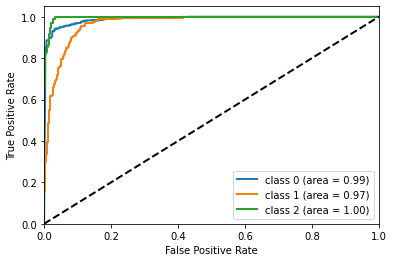

In [ ]:
roc_plot(test_rsi_Y, rsi_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


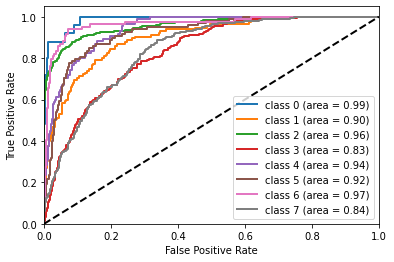

In [ ]:
roc_plot(test_pat_Y, pat_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


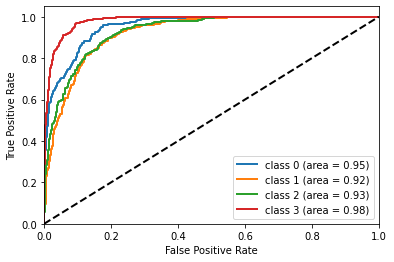

In [ ]:
roc_plot(test_vol_Y, vol_pred)

In [ ]:
# roc_plot(test_tar_Y_one, tar_pred)

In [ ]:
####roc curve######

n_classes = test_vol_Y.shape[1]

fpr = dict()   #false positive rate
tpr = dict()   #true positive rate
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i],_=roc_curve(test_vol_Y[:,i], vol_pred[:,i] )
  roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"],_= roc_curve(test_vol_Y.ravel(), vol_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

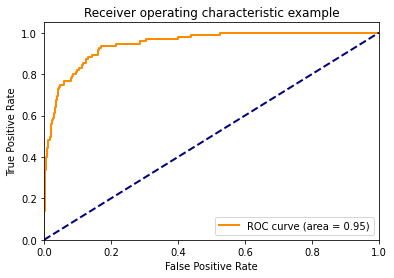

In [ ]:
###한개 클래스에 대해서만 roc 곡선 그리기
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


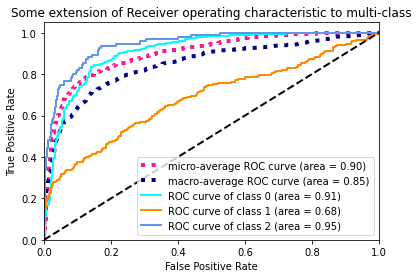

In [ ]:
from itertools import cycle
from scipy import interp

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','orchid'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


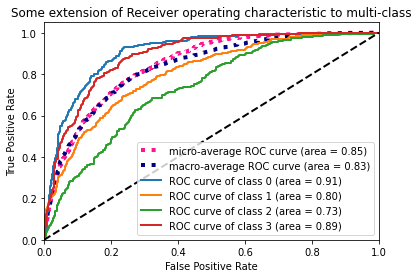

In [ ]:
from itertools import cycle
from scipy import interp

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue','orchid'])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# model.json 파일열기
json_file = open(base_path + "models/rsi_model_1117.json", "r")
loaded_model_json = json_file.read()
json_file.close()

from tensorflow.compat.v2.keras.models import model_from_json
# json파일로부 터 model 로드하기
loaded_rsi = model_from_json(loaded_model_json)

# 로드 한모델 에 weight 로드하기
loaded_rsi.load_weights(base_path + 'models/rsi_model_1117_weitght.h5')

# 모 델 컴파일
loaded_rsi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.json 파일열기
json_file = open(base_path + "models/pat_model_1117.json", "r")
loaded_model_json = json_file.read()
json_file.close()

from tensorflow.compat.v2.keras.models import model_from_json
# json파일로부 터 model 로드하기
loaded_pat = model_from_json(loaded_model_json)

# 로드 한모델 에 weight 로드하기
loaded_pat.load_weights(base_path + 'models/pat_model_1117_weitght.h5')

# 모 델 컴파일
loaded_pat.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.json 파일열기
json_file = open(base_path + "models/vol_model_1117.json", "r")
loaded_model_json = json_file.read()
json_file.close()

from tensorflow.compat.v2.keras.models import model_from_json
# json파일로부 터 model 로드하기
loaded_vol = model_from_json(loaded_model_json)

# 로드 한모델 에 weight 로드하기
loaded_vol.load_weights(base_path + 'models/vol_model_1117_weitght.h5')

# 모 델 컴파일
loaded_vol.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(54,36;334.8x217.44)
Trend: 0 (100.00%) ----- Label: 0
Pattern: 3 (92.39%) ----- Label: 3
Volatility: 2 (96.74%) ----- Label: 2
Result: up (51.02%) ----- Label: ['up']


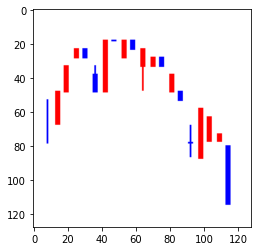

In [ ]:
###example image input (설명결과예시)
idx=27

print(plt.imshow(ptestX[idx]))

#(rsiProba, rocProba, volProba) = model.predict(np.expand_dims(testX[idx], axis=0)) #, colorProba, styleProba)

rsiProba = loaded_rsi.predict(np.expand_dims(ptestX[idx], axis=0))
volProba = loaded_vol.predict(np.expand_dims(ptestX[idx], axis=0))
patProba = loaded_pat.predict(np.expand_dims(ptestX[idx], axis=0))
tarProba = result_model.predict(np.expand_dims(test_x[idx],axis=0))


rsiIdx = rsiProba[0].argmax()
volIdx = volProba[0].argmax()
patIdx = patProba[0].argmax()
tarIdx = tarProba[0].argmax()
# colorIdx = colorProba[0].argmax()
# styleIdx = styleProba[0].argmax()

rsiLabel = rsiLB.classes_[rsiIdx]
patLabel = patLB.classes_[patIdx]
volLabel = volLB.classes_[volIdx]
tarLabel = tarLB.classes_[tarIdx]
# colorLabel = seasonLB.classes_[colorIdx]
# styleLabel = usageLB.classes_[styleIdx]

rsiText = "Trend: {} ({:.2f}%)".format(rsiLabel, rsiProba[0][rsiIdx] * 100)
patText = "Pattern: {} ({:.2f}%)".format(patLabel, patProba[0][patIdx] * 100)
volText = "Volatility: {} ({:.2f}%)".format(volLabel, volProba[0][volIdx] * 100)
tarText = "Result: {} ({:.2f}%)".format(tarLabel, tarProba[0][tarIdx] * 100)
# colorText = "Color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
# styleText = "Style: {} ({:.2f}%)".format(styleLabel, styleProba[0][styleIdx] * 100)

print(rsiText, '-----','Label:', rsiLB.classes_[ptest_rsi_Y[idx]].argmax())
print(patText, '-----','Label:',patLB.classes_[test_pat_Y[idx]].argmax())
print(volText, '-----','Label:',volLB.classes_[ptest_vol_Y[idx]].argmax())
print(tarText, '-----','Label:',tarLB.classes_[test_y[idx]])         ###up:1, down=0
# print(colorText, '-----',seasonLB.classes_[testSeasonY[idx].argmax()])
# print(styleText, '-----',usageLB.classes_[testUsageY[idx].argmax()])

In [ ]:
test_y

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:
from matplotlib import pyplot as plt
# plt.imshow(np.expand_dims(testX[idx], axis=0), interpolation='nearest')
# plt.show()

In [ ]:
import numpy as np
from PIL import Image

# pil_image=Image.fromarray(np.expand_dims(testX[idx], axis=0))
# pil_image.show()

In [ ]:
testX[idx].shape

(28, 28, 3)

In [ ]:
Image.fromarray(testX[idx].astype('uint8'),'RGB')

In [ ]:
test_vol_Y

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [ ]:
test_id.reset_index(drop=True,inplace=True)

In [ ]:
test_id[idx]

'/content/drive/MyDrive/졸업논문/dataset/all_images/007340.KS_2.jpg'

In [ ]:
test_id[idx]
plt.show()

KeyError: ignored

In [ ]:
#image = cv2.imread(imagePath)
image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = preprocess_input(image)


In [ ]:
image = cv2.imread(image_ids[6176])

In [ ]:
image.shape

(1207, 1934, 3)

In [ ]:
a = cv2.resize(testX[idx], (100, 100))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


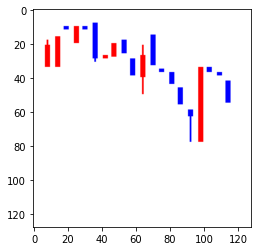

In [ ]:
%matplotlib inline
plt.imshow(testX[idx])

In [ ]:
Image.fromarray(a.astype('uint8'),'BGR')

ValueError: ignored